## Data preparation

In [1]:
import pandas as pd
import json
import mplfinance as mpl
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
import os
from IPython import display
from sklearn.preprocessing import StandardScaler

2022-05-20 11:08:54.324319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-20 11:08:54.324371: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
with open('./Training data/googl.json') as f:
    data = json.load(f)
raw_df = pd.DataFrame(data["Weekly Time Series"]).T
raw_df = raw_df.rename(lambda x: x.split(' ')[1], axis=1)
for c in raw_df.columns:
    raw_df[c] = pd.to_numeric(raw_df[c])
raw_df.index = pd.to_datetime(raw_df.index)
raw_df = raw_df.sort_index()
raw_df

,open,high,low,close,volume
2004-08-27,110.7600,113.4800,103.5700,106.15,55998500
2004-09-03,105.2800,105.4900,98.9400,100.01,39523700
2004-09-10,101.0100,106.5600,99.6100,105.33,23593600
2004-09-17,106.6300,117.4900,106.4600,117.49,48124800
2004-09-24,116.9500,124.1000,116.7700,119.83,43097600
...,...,...,...,...,...
2022-02-25,2596.7618,2705.4300,2499.0650,2689.19,8405453
2022-03-04,2661.0000,2728.7899,2606.7500,2638.13,7196673
2022-03-11,2629.7600,2675.9100,2513.4937,2597.41,9059664
2022-03-18,2605.0000,2724.8800,2505.5000,2722.51,8882203


## Baseline model

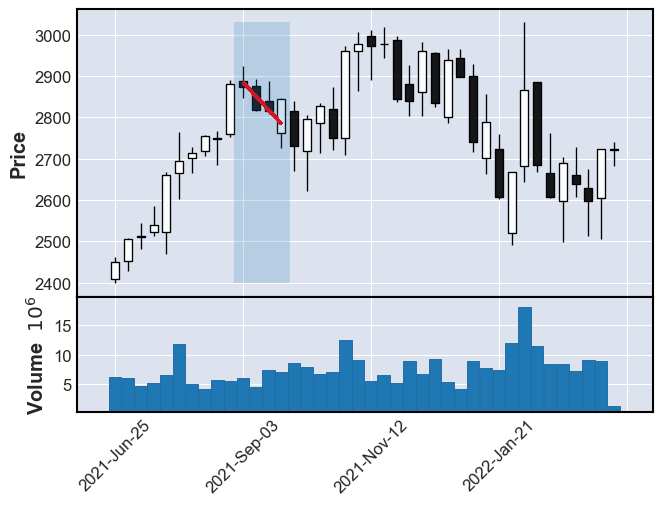

In [3]:
mpl.plot(raw_df[-40:], type='candle', volume=True, vlines=dict(vlines='2021-09-11',linewidths=40,alpha=0.2), alines=dict(alines=[('2021-09-3', 2885),('2021-09-24',2785)], colors='r'))

accuracy 38.88888888888889%


/tmp/ipykernel_6832/486195391.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


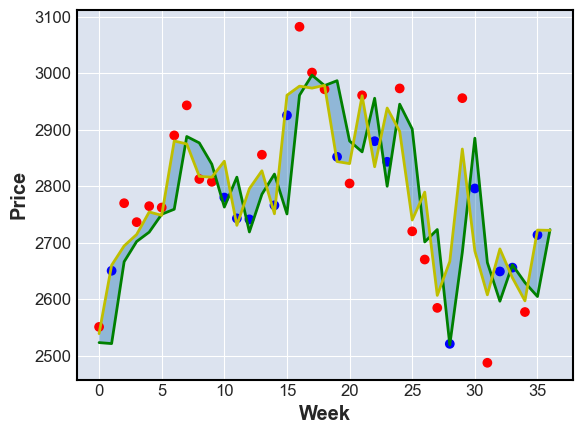

In [4]:
def simple_predictions(df):
    success = 0
    forecast = []
    for x in range(3, len(df)-1):
        interpolate = interp1d(range(4), [(df.iloc[row]['open'] + df.iloc[row]['close']) / 2 for row in range(x-3, x+1)], kind='slinear', fill_value='extrapolate', bounds_error=False)
        forecast.append(t:=interpolate(4))
        if  df.iloc[x+1]['open'] <= t <= df.iloc[x+1]['close'] or df.iloc[x+1]['open'] >= t >= df.iloc[x+1]['close']:
            success += 1
    print(f'accuracy {success/(len(df)-4)*100}%')
    fig, ax = plt.subplots()
    ax.fill_between(range(0, len(df)-3), df['open'][3:], df['close'][3:], alpha=0.4)
    ax.plot(range(0, len(df)-3), df['open'][3:], color='g')
    ax.plot(range(0, len(df)-3), df['close'][3:], color='y')
    ax.scatter(range(0, len(df)-4), forecast, c=np.array([[0., 0., 1.] if df.iloc[3 + i]['open'] <= forecast[i] <= df.iloc[3+i]['close'] or df.iloc[3+i]['open'] >= forecast[i] >= df.iloc[3+i]['close'] else [1., 0., 0.] for i in range(len(forecast))]))
    ax.set_xlabel('Week')
    ax.set_ylabel('Price')
    fig.show()
    
simple_predictions(raw_df[-40:])

## First nerual network model

In [22]:
with open('./Training data/googl-daily.json') as f:
    data = json.load(f)
raw_df = pd.DataFrame(data["Time Series (Daily)"]).T
raw_df = raw_df.rename(lambda x: x.split(' ')[1], axis=1)
for c in raw_df.columns:
    raw_df[c] = pd.to_numeric(raw_df[c])
raw_df.index = pd.to_datetime(raw_df.index)
raw_df = raw_df.sort_index()
raw_df

,open,high,low,close,volume
2004-08-19,100.01,104.0600,95.960,100.335,44659000
2004-08-20,101.01,109.0800,100.500,108.310,22834300
2004-08-23,110.76,113.4800,109.050,109.400,18256100
2004-08-24,111.24,111.6000,103.570,104.870,15247300
2004-08-25,104.76,108.0000,103.880,106.000,9188600
...,...,...,...,...,...
2022-03-24,2784.00,2832.3750,2755.010,2831.440,1319828
2022-03-25,2838.32,2840.7000,2794.750,2833.460,1204457
2022-03-28,2818.01,2840.0500,2796.225,2829.110,1752463
2022-03-29,2852.95,2875.8700,2840.765,2850.110,1715851


In [23]:
df = raw_df[:len(raw_df)-1].to_numpy() #take out the last data point since we dont have future data to validate predictions
y_df = np.array([(row[0]+row[1])/2 for row in df[1:, [0, 3]]])
x_df = df[:-1]
x_train = x_df[:-100] 
y_train = y_df[:-100]
x_test = x_df[-100:]
y_test = df[1:, [0, 3]][-100:]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(4333, 5) (4333,) (100, 5) (100, 2)


In [24]:
tf.random.set_seed(7)
inputs = keras.Input(shape=(5,))
x = keras.layers.Dense(5, activation="relu")(inputs)
x = keras.layers.Dense(6, activation="relu")(x)
x = keras.layers.Dense(3, activation="relu")(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=output, name="perceptronMulticapa")
model.summary()

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
)
history = model.fit(
    x_train[:-100], y_train[:-100],
    validation_data=(x_train[-100:], y_train[-100:]), 
    batch_size=3, epochs=75, shuffle=False, 
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Model: "perceptronMulticapa"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_9 (Dense)             (None, 5)                 30        
                                                                 
 dense_10 (Dense)            (None, 6)                 36        
                                                                 
 dense_11 (Dense)            (None, 3)                 21        
                                                                 
 dense_12 (Dense)            (None, 1)                 4         
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
1411/1411 [=============================

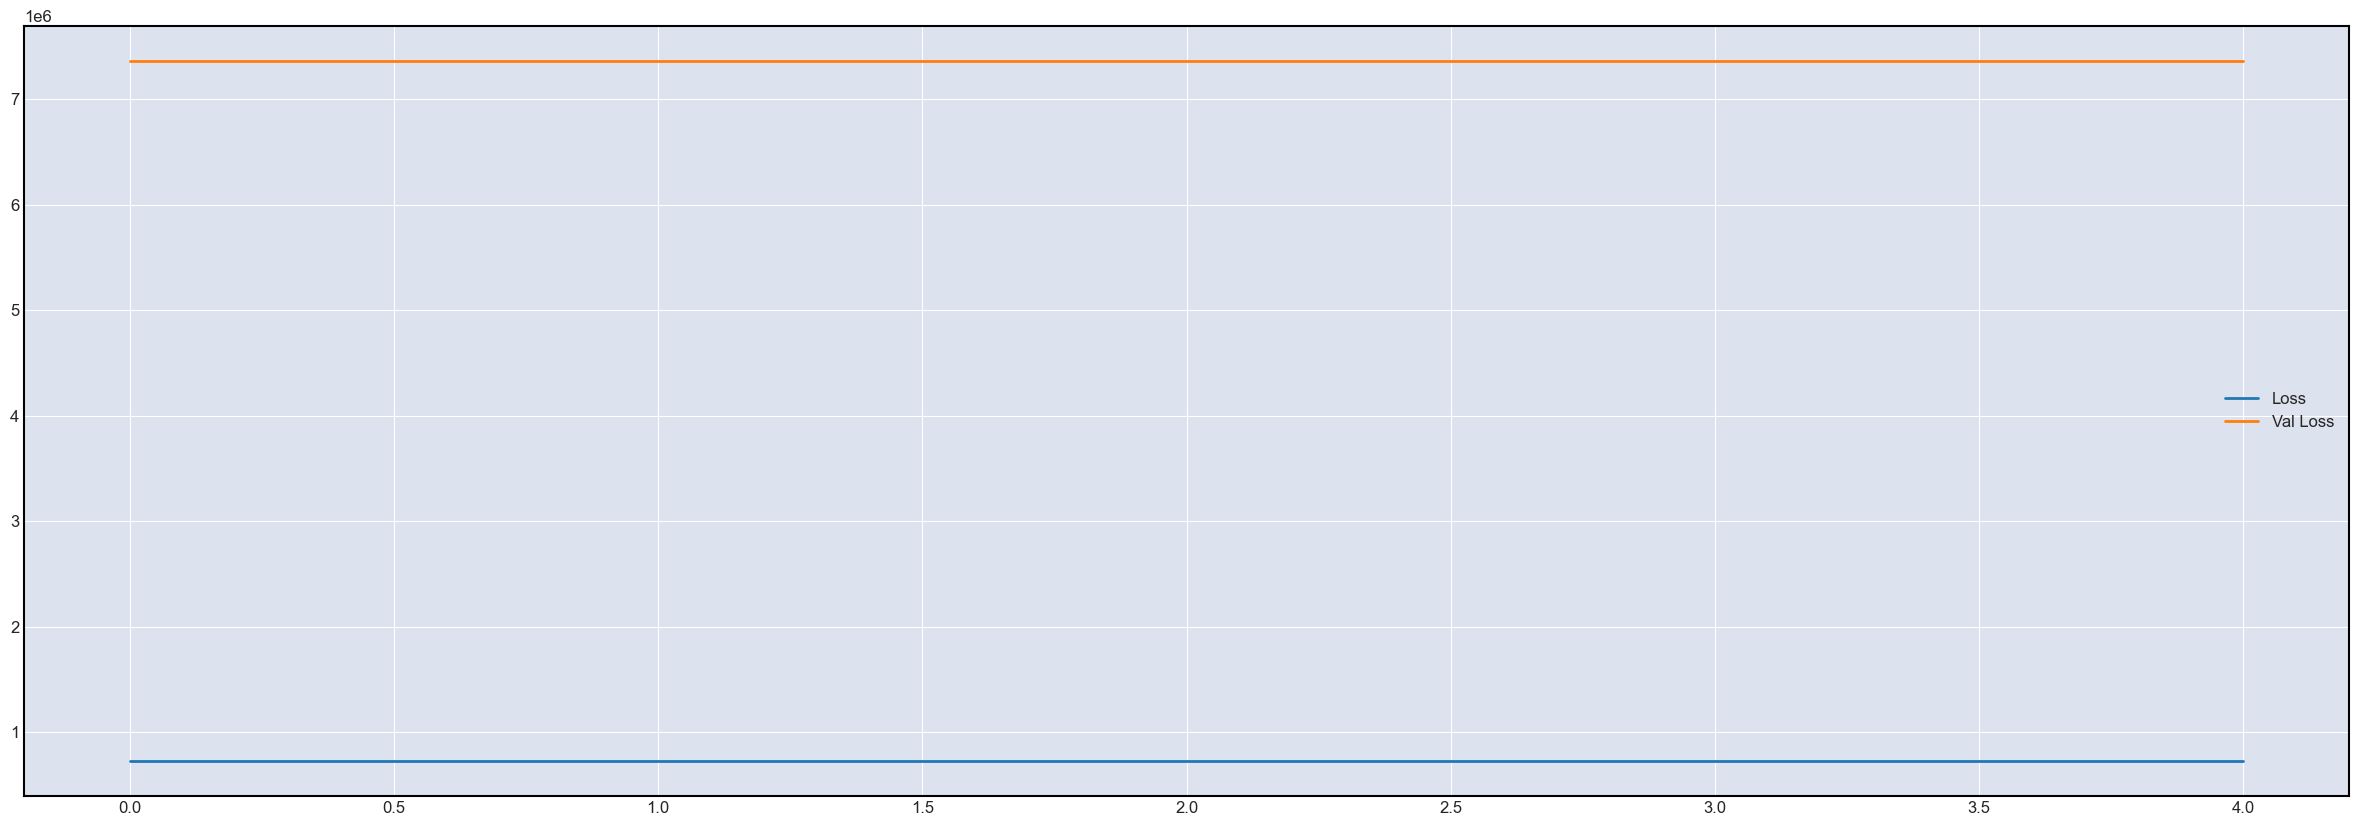

In [25]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'][1:], label='Loss')
ax.plot(history.history['val_loss'][1:], label='Val Loss')
ax.legend()

In [26]:
results = model.predict(x_test)
results[:15]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

accuracy 0.0%


/tmp/ipykernel_6832/3214409657.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


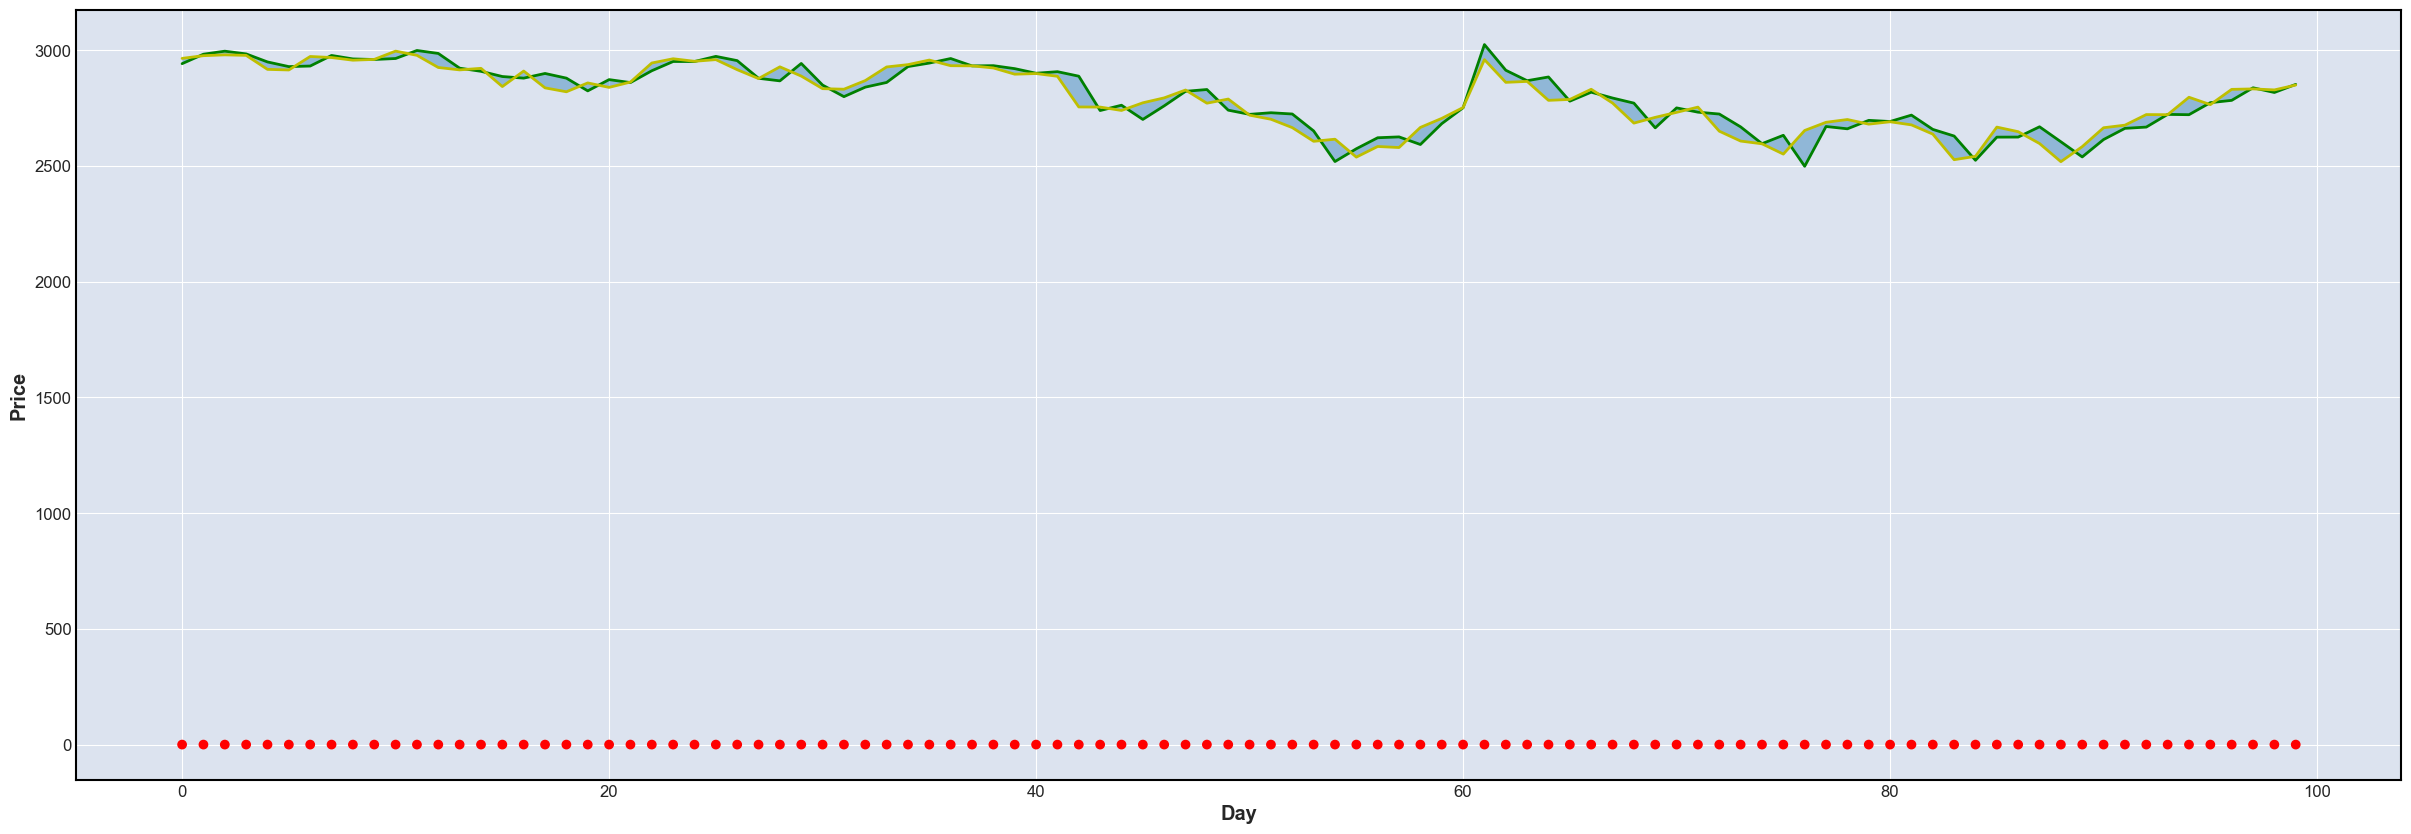

In [27]:
def evaluation(predictions, actual):
    aux = [True if actual[x][0] <= predictions[x] <= actual[x][1] or actual[x][1] <= predictions[x] <= actual[x][0] else False for x in range(len(predictions))]
    print(f'accuracy {(aux.count(True)/len(aux))*100}%')
    fig, ax = plt.subplots()
    ax.fill_between(range(len(predictions)), [x[0] for x in actual], [x[1] for x in actual], alpha=0.4)
    ax.plot(range(len(predictions)), [x[0] for x in actual], color='g')
    ax.plot(range(len(predictions)), [x[1] for x in actual], color='y')
    ax.scatter(range(len(predictions)), predictions, c=np.array([[0., 0., 1.] if actual[i][0] <= predictions[i] <= actual[i][1] or actual[i][1] <= predictions[i] <= actual[i][0] else [1., 0., 0.] for i in range(len(predictions))]))
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    fig.show()
evaluation(results, y_test)

In [11]:
def get_last_version(model_path):
    if not os.path.exists(model_path):
        return '1'
    versions = [x for x in os.listdir(model_path)]
    versions.sort()
    return str(int(versions[-1]) + 1)

In [12]:
tf.saved_model.save(model, os.path.join('mlp_model', get_last_version('./mlp_model')))

2022-05-20 11:09:14.816252: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: mlp_model/4/assets


## Recurrent Neural Network

In [13]:
def week_batch_generator(raw, scaler):
    raw_df = scaler.transform(raw)
    df_x = raw_df[:-1]
    df_y = np.array([(x[0]+x[3])/2 for x in raw_df[1:]])
    x_batch = df_x[:-(len(df)%5)].reshape((len(df_x)//5, 5, 5)) 
    y_batch = df_y[:-(len(df)%5)].reshape(len(df_y)//5, 5, -1)
    return (x_batch[:-100], y_batch[:-100]), (x_batch[-100:], np.array(raw_df[1:-(len(df)%5),[0, 3]][-100:]))

(x_train, y_train), (x_test, y_test) = week_batch_generator(raw_df.to_numpy(), scaler:= StandardScaler().fit(raw_df.to_numpy()))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train

(786, 5, 5) (786, 5, 1) (100, 5, 5) (100, 2)


array([[[-1.28526911, -1.28057307, -1.29001887, -1.28448461,
          4.970593  ],
        [-1.28353222, -1.27193325, -1.28205529, -1.27063421,
          2.13246779],
        [-1.26659758, -1.2643605 , -1.2670578 , -1.26874118,
          1.53711002],
        [-1.26576388, -1.26759613, -1.27667023, -1.27660855,
          1.14583998],
        [-1.2770189 , -1.27379202, -1.27612646, -1.27464605,
          0.35795519]],

       [[-1.27668889, -1.27387807, -1.27475826, -1.2713289 ,
          0.08567348],
        [-1.2712177 , -1.27272495, -1.27295155, -1.27438554,
         -0.02916651],
        [-1.27611572, -1.27811193, -1.27940661, -1.2815756 ,
         -0.16115903],
        [-1.2812569 , -1.28117545, -1.27914349, -1.28095037,
         -0.19742771],
        [-1.28059689, -1.28244905, -1.28351118, -1.28463224,
          0.35140108]],

       [[-1.28686704, -1.2834817 , -1.28479167, -1.28244396,
          1.12910359],
        [-1.28363644, -1.28456598, -1.28412512, -1.28504905,
         -0

In [14]:
colors = [
    '#333333',
    '#ffffff'
]
class MyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        plt.rcParams["figure.figsize"] = (30,10)
        fig, ax = plt.subplots()
        fig.suptitle(f"epoch: {epoch}, {logs}")
        history = list(logs.keys())
        for key in history:
            if key not in self.valores:
                self.valores[key] = []
            self.valores[key].append(logs[key])
            ax.plot(self.valores[key], label = key, c = colors[0 if "loss" in key else 1], linestyle='--' if 'val' in key else '-')
            ax.legend(loc = "upper right" if "loss" in key else "upper left")
        plt.show()
        display.clear_output(wait = True)
    def __init__(self):
        self.valores = {}
    def on_train_end(self, logs = None):
        print(f"Finished: {logs}")

In [15]:
inputs = keras.layers.Input(shape=(x_train.shape[1:]))
x = keras.layers.LSTM(3, activation=keras.layers.LeakyReLU() , return_sequences=True)(inputs)
x = keras.layers.Dropout(0.2)(x)
#x = keras.layers.BatchNormalization()(x)
x = keras.layers.LSTM(2, activation=keras.layers.LeakyReLU() , return_sequences=False)(x)
x = keras.layers.Dropout(0.2)(x)
#x = keras.layers.BatchNormalization()(x)
output = keras.layers.Dense(1, activation='linear')(x)
model_lstm = keras.Model(inputs=inputs, outputs=output, name="v1.0")
model_lstm.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
)
history = model_lstm.fit(
    x_train[:-100], y_train[:-100],
    validation_data=(x_train[-100:], y_train[-100:]), 
    batch_size=32, epochs=100, shuffle=False,
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        MyCallback()
    ]
)

Finished: {'loss': 0.36898624897003174, 'val_loss': 0.5287486910820007}


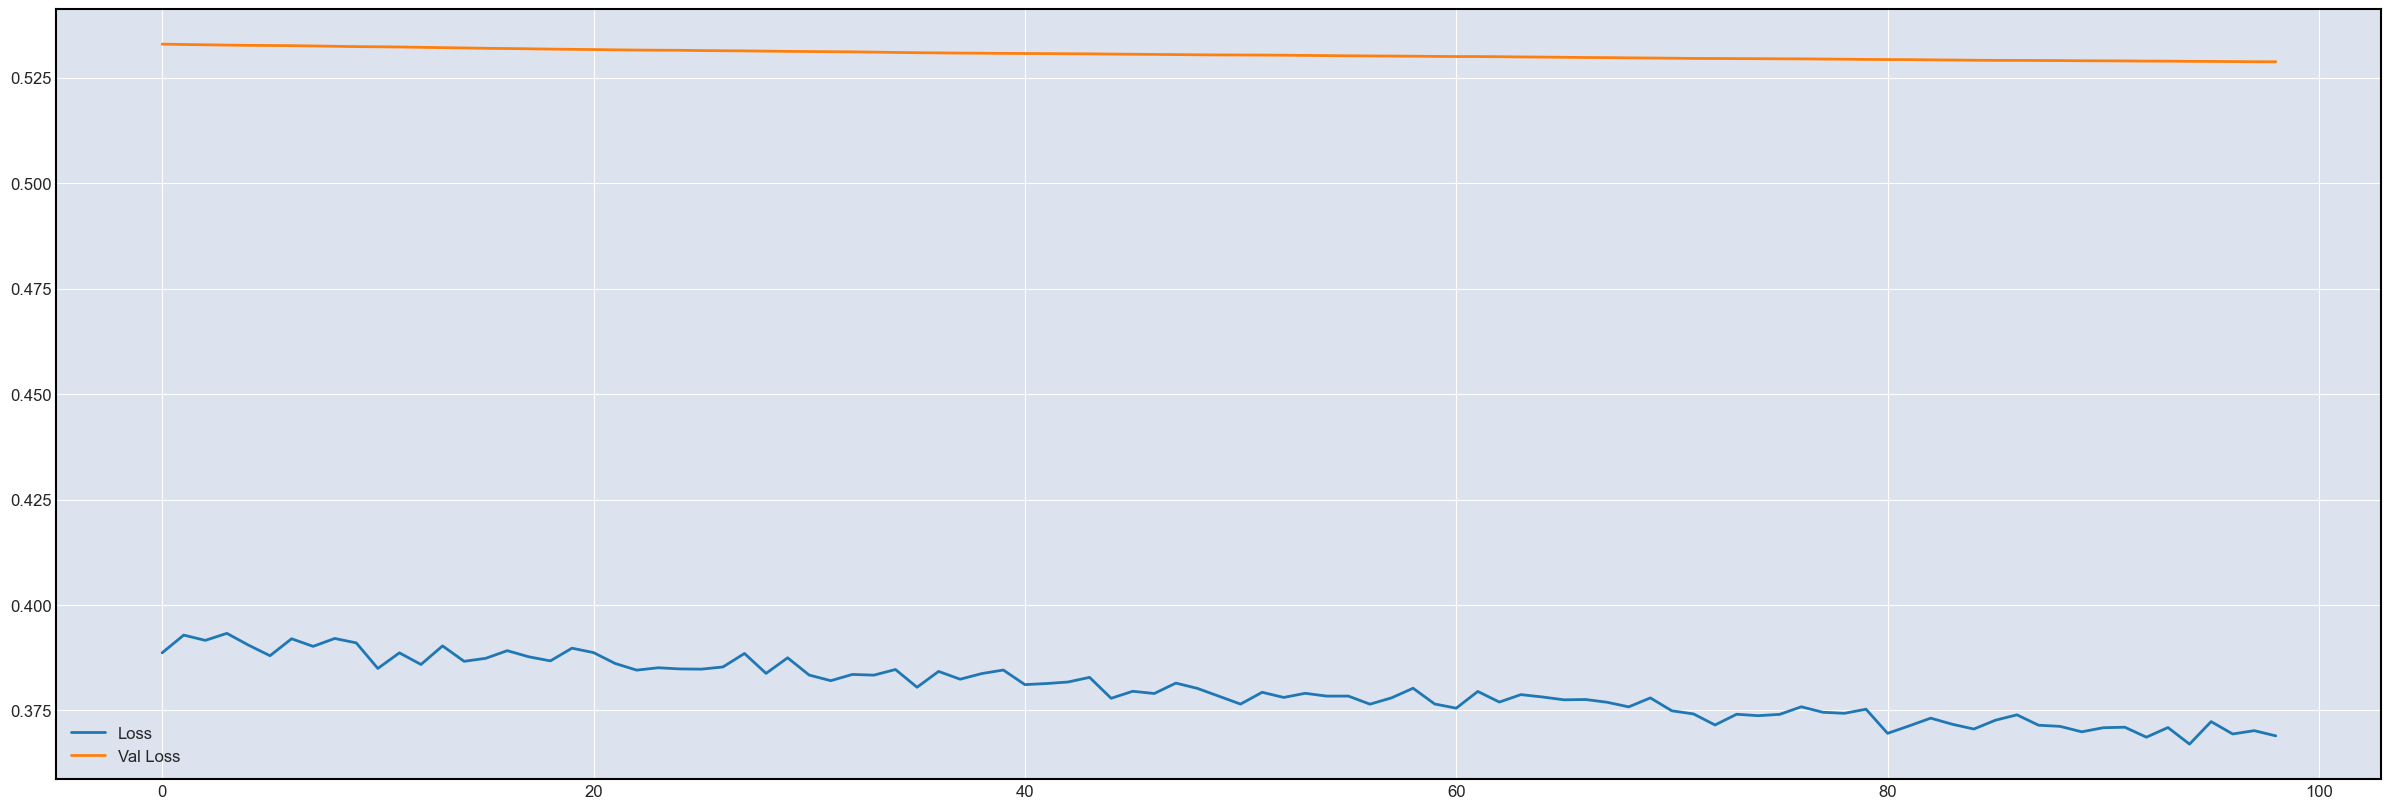

In [16]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'][1:], label='Loss')
ax.plot(history.history['val_loss'][1:], label='Val Loss')
ax.legend()

In [17]:
results_lstm = (model_lstm.predict(x_test) * scaler.var_[4] ) + scaler.mean_[4] #echarle un vistazo a la parte de normalizacion
results_lstm

array([[-4.6439858e+12],
       [-5.2156029e+12],
       [-5.5609839e+12],
       [-5.6962795e+12],
       [-5.5411123e+12],
       [-6.6317388e+12],
       [-6.2221200e+12],
       [-6.5588119e+12],
       [-6.8727425e+12],
       [-6.7532284e+12],
       [-6.6593096e+12],
       [-6.5905078e+12],
       [-5.9745727e+12],
       [-6.4970278e+12],
       [-6.9176189e+12],
       [-7.2010716e+12],
       [-7.1940304e+12],
       [-6.3026810e+12],
       [-7.3778452e+12],
       [-7.3931162e+12],
       [-7.1482841e+12],
       [-7.1415575e+12],
       [-6.6739267e+12],
       [-7.0127777e+12],
       [-6.4627168e+12],
       [-6.8537837e+12],
       [-7.0715688e+12],
       [-6.8737182e+12],
       [-6.9369520e+12],
       [-6.6849934e+12],
       [-6.8289015e+12],
       [-7.1750606e+12],
       [-8.0099866e+12],
       [-7.8658273e+12],
       [-7.7066928e+12],
       [-7.7445826e+12],
       [-7.1644008e+12],
       [-8.0721997e+12],
       [-7.6627784e+12],
       [-7.2353102e+12],


accuracy 0.0%


/tmp/ipykernel_6832/3603104495.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


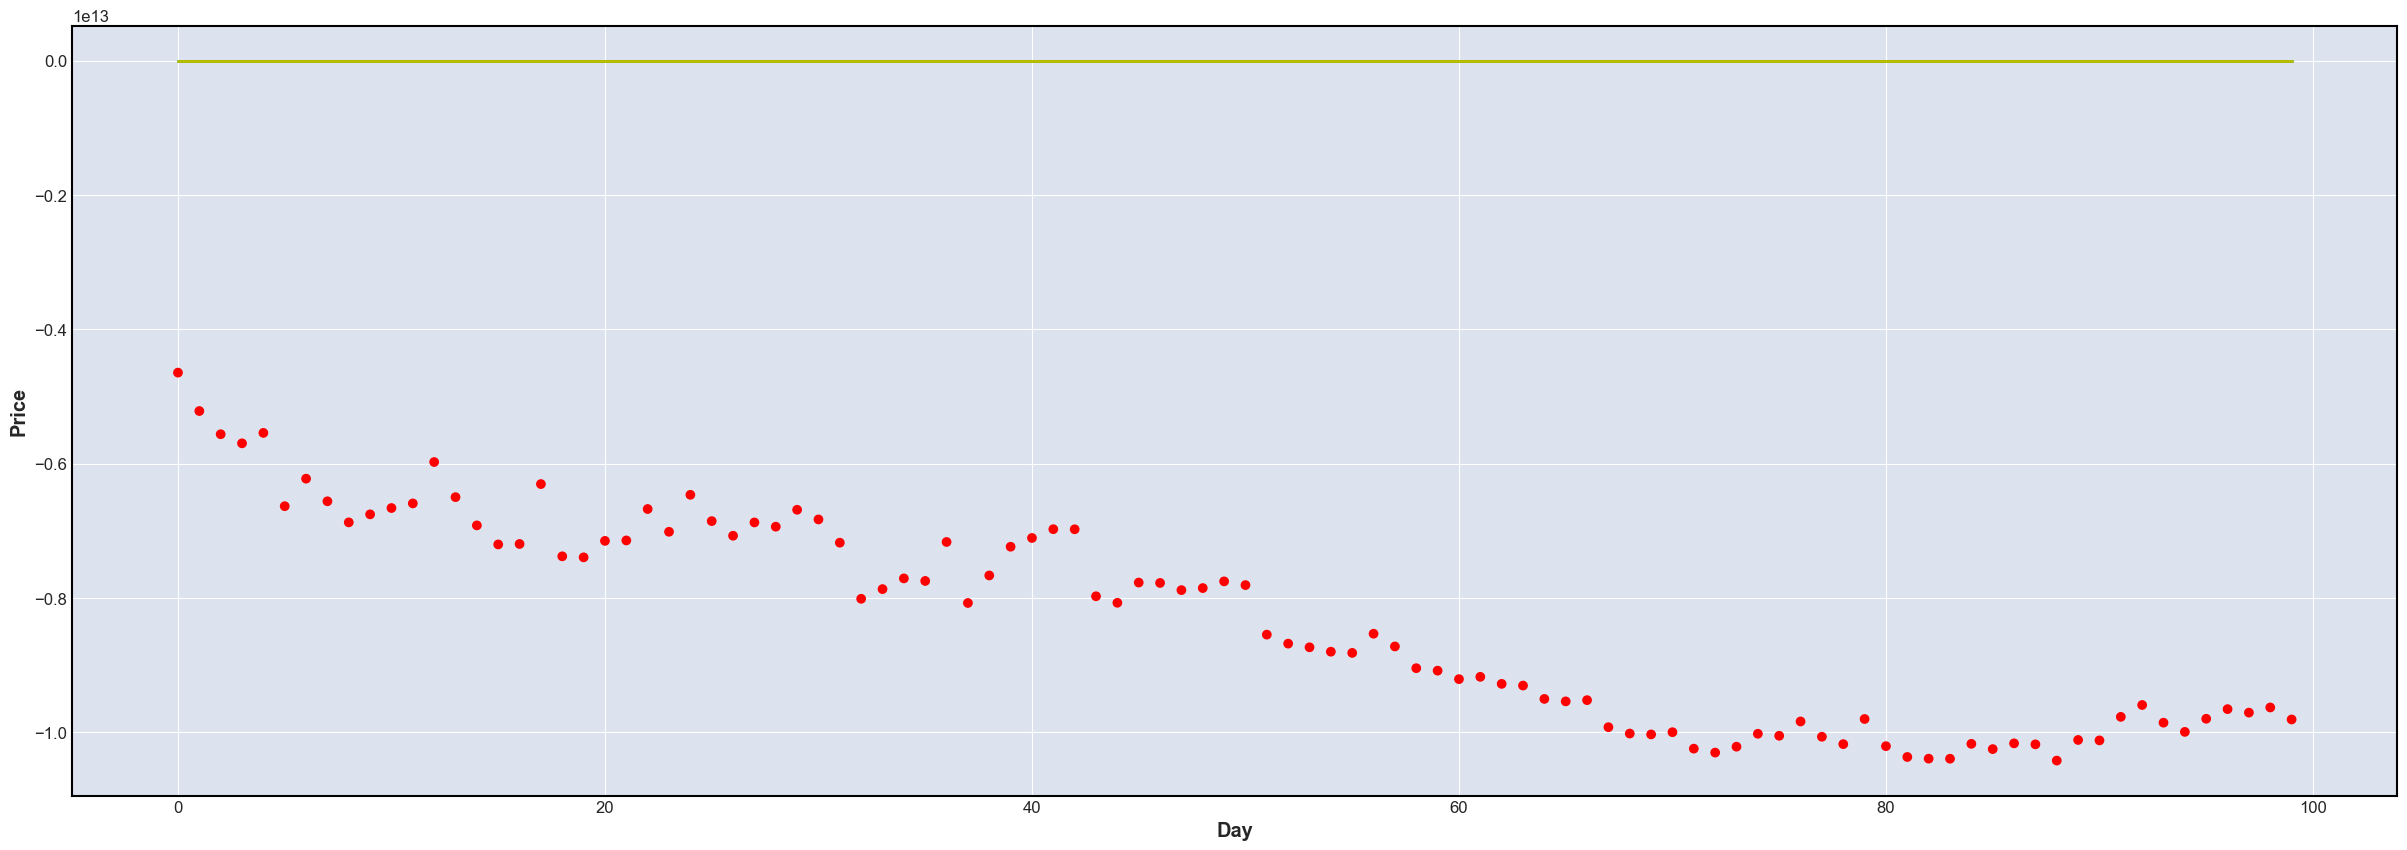

In [18]:
def evaluation_lstm(predictions, actual):
    aux = [True if actual[x][0] <= predictions[x] <= actual[x][1] or actual[x][1] <= predictions[x] <= actual[x][0] else False for x in range(len(predictions))]
    print(f'accuracy {(aux.count(True)/len(aux))*100}%')
    fig, ax = plt.subplots()
    ax.fill_between(range(len(predictions)), [x[0] for x in actual], [x[1] for x in actual], alpha=0.4)
    ax.plot(range(len(predictions)), [x[0] for x in actual], color='g')
    ax.plot(range(len(predictions)), [x[1] for x in actual], color='y')
    ax.scatter(range(len(predictions)), predictions, c=np.array([[0., 0., 1.] if actual[i][0] <= predictions[i] <= actual[i][1] or actual[i][1] <= predictions[i] <= actual[i][0] else [1., 0., 0.] for i in range(len(predictions))]))
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    fig.show()
evaluation_lstm(results_lstm, y_test)